In [ ]:
!killall python3

In [1]:
#import sys
#!{sys.executable} -m pip install --upgrade jax==0.2.10 jaxlib==0.1.62+cuda101 -f https://storage.googleapis.com/jax-releases/jax_releases.html
#!{sys.executable} -m pip install --upgrade numpyro
#!{sys.executable} -m pip install --upgrade arviz


In [2]:
#import os
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" # so the IDs match nvidia-smi
#os.environ["CUDA_VISIBLE_DEVICES"] = "0" # "0, 1" for multiple

import jax
import jax.numpy as jnp
from jax import random

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import print_summary, hpdi
from numpyro.infer import Predictive, SVI, Trace_ELBO, NUTS, MCMC, RenyiELBO
from numpyro.infer.autoguide import AutoLaplaceApproximation
import numpyro.infer.initialization as init
from numpyro.handlers import reparam
from numpyro.infer.reparam import LocScaleReparam, TransformReparam

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import numpy as np

from tqdm import tqdm

from sklearn.metrics import roc_curve, roc_auc_score

In [3]:
numpyro.set_platform("gpu")

In [4]:
#MODE = "full"
MODE = "validate"

In [5]:

def parse_filename(filename):
    filename = os.path.split(filename)[-1]
    filename = os.path.splitext(filename)[0]
    groupsize, coherence, trial = filename.split("_", 2)
    date, _ = trial.split("_")
    return int(groupsize), float(coherence), trial, date

def filter_files(data_files):
    filtered = []
    for filename in data_files:
        groupsize, coherence, trial, date = parse_filename(filename)
        if (not date.startswith('20181026')):
            filtered.append(filename)
    return filtered

def get_trial_lookup(data_files):
    trials = []
    for filename in data_files:
        groupsize, coherence, trial, date = parse_filename(filename)        
        trials.append(trial)
    return dict(zip(trials, range(len(trials))))

def get_date_lookup(data_files):
    dates = []
    for filename in data_files:
        groupsize, coherence, trial, date = parse_filename(filename)        
        dates.append(date)
    dates = np.unique(dates)
    return dict(zip(dates, range(len(dates))))


def train_test_split(df, train_percent=.8, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    train = df.iloc[perm[:train_end]]
    test = df.iloc[perm[train_end:]]
    return train, test

def load_data_files(data_files):
    if MODE == "full":
        df_list = []
    elif MODE =="validate":
        df_train_list = []
        df_test_list = []
    data_files = filter_files(data_files)
    trial_lookup = get_trial_lookup(data_files)
    date_lookup = get_date_lookup(data_files)
    for filename in tqdm(data_files):
        groupsize, coherence, trial, date = parse_filename(filename)
        data = np.load(filename)
        
        if (data[data == 0].shape[0] / data.shape[0]) == 1.0:
            continue
        
        samples_per_trial = 1000#data.shape[0]#1000
        if data.shape[0] > samples_per_trial:
            data = np.random.choice(data, size=samples_per_trial, replace=False).astype(np.float32)
        df = pd.DataFrame()
        df["rotation"] = data
        df["groupsize"] = groupsize
        df["coherence"] = coherence
        df["trial"] = trial
        df["trial_category"] = trial_lookup[trial]
        df["date"] = date
        df["date_category"] = date_lookup[date]
        if MODE =="full":
            df_list.append(df)
        elif MODE == "validate":
            df_train, df_test = train_test_split(df)
            df_train_list.append(df_train)
            df_test_list.append(df_test)
    if MODE == "full":
        df = pd.concat(df_list)
        return df, trial_lookup, date_lookup
    elif MODE == "validate":
        df_train = pd.concat(df_train_list)
        df_test = pd.concat(df_test_list)
        return df_train, df_test, trial_lookup, date_lookup

data_files = sorted(glob.glob("/home/jake/dan_bath_data/191205_rotation_data/*.npy"))[::-1]
if MODE == "full":
    df, trial_lookup, date_lookup = load_data_files(data_files)
if MODE == "validate":
    df_train, df_test, trial_lookup, date_lookup = load_data_files(data_files)

100%|██████████| 581/581 [00:58<00:00,  9.90it/s]


In [6]:
df_train.head()

,rotation,groupsize,coherence,trial,trial_category,date,date_category
629,0.988921,8,1.0,20190923_145201,0,20190923,38
373,-0.935811,8,1.0,20190923_145201,0,20190923,38
450,0.941150,8,1.0,20190923_145201,0,20190923,38
617,0.813570,8,1.0,20190923_145201,0,20190923,38
776,0.999966,8,1.0,20190923_145201,0,20190923,38


In [7]:
def normalize(x):
    return x * 2 - 1

def log2_scale(x, min_size=4., max_size=1024.):
    return jnp.log2(x / min_size) / jnp.log2(max_size / min_size)

def inv_log2_scale(x, min_size=4., max_size=1024.):
    inv = x * jnp.log2(max_size / min_size)
    inv = 2**inv
    inv *= min_size
    return inv

def inv_normalize(x):
    return (x + 1) / 2

def exp_scale(x, min_size=4., max_size=1024.):
    return (x - min_size) / (max_size - min_size)

def inv_softplus(x):
    return x + jnp.log(-jnp.expm1(-x))  # == log(expm1(x))


In [8]:
def additive_partial_pooling_model(groupsize, coherence, trial=None, n_trials=None, date=None, n_dates=None, rotation=None, inference=False):
    G = normalize(log2_scale(groupsize))
    C = normalize(coherence)
    data = jnp.concatenate((G, C, C * G), axis=-1)
    
    w0_population = numpyro.sample(
        "w0_population",
        dist.Normal(
            loc=jnp.zeros((data.shape[-1], 2)),
            scale=1
        ),
    )
    b0_population = numpyro.sample(
        "b0_population",
        dist.Normal(
            loc=jnp.array([0, inv_softplus(2)]),
            scale=0.1
        ),
    )

    if trial is None and date is None:
        z0 = jnp.matmul(data, w0_population) + b0_population
    else:
        with numpyro.plate("trial", n_trials, dim=-3):
            config = {
                "w0_trial": LocScaleReparam(0),
                "b0_trial": LocScaleReparam(0),
                     }
            with numpyro.handlers.reparam(config=config):
                w0_trial = numpyro.sample(
                    "w0_trial",
                    dist.Normal(
                        loc=jnp.zeros((data.shape[-1], 2)),
                        scale=0.1
                    ),
                )
                b0_trial = numpyro.sample(
                    "b0_trial",
                    dist.Normal(
                        loc=jnp.zeros((2,)),
                        scale=0.1
                    ),
                ).squeeze()
                
        with numpyro.plate("date", n_dates, dim=-3):
            config = {
                "w0_date": LocScaleReparam(0),
                "b0_date": LocScaleReparam(0),
                     }
            with numpyro.handlers.reparam(config=config):
                w0_date = numpyro.sample(
                    "w0_date",
                    dist.Normal(
                        loc=jnp.zeros((data.shape[-1], 2)),
                        scale=0.1
                    ),
                )
                b0_date = numpyro.sample(
                    "b0_date",
                    dist.Normal(
                        loc=jnp.zeros((2,)),
                        scale=0.1
                    ),
                ).squeeze()
        
        w0 = w0_population + w0_trial[trial] + w0_date[date]
        b0 = b0_population + b0_trial[trial] + b0_date[date]
        z0 = jnp.einsum('ij,ijk->ik', data, w0) + b0

    raw_params = z0
    logit_loc, log_scale = jnp.split(raw_params, 2, axis=-1)
    
    loc = jnp.clip(jax.nn.sigmoid(logit_loc), 1e-5, (1 - 1e-5))        
    scale = jnp.clip(jax.nn.softplus(log_scale), 1e-5)

    if inference:
        scale = numpyro.deterministic("scale", scale)
        loc = numpyro.deterministic("loc", loc)

    A = (loc * scale) + 1e-5
    B = ((1 - loc) * scale) + 1e-5
    if inference:
        numpyro.deterministic("A", A)
        numpyro.deterministic("B", B)

    if rotation is not None:
        R = (rotation + 1) / 2
        R = jnp.clip(R, 1e-5, (1 - 1e-5))
    else:
        R = rotation
    if inference and R is not None:
        numpyro.deterministic("log likelihood", dist.Beta(A, B).log_prob(R))
    numpyro.sample("R", dist.Beta(A, B), obs=R)


In [9]:
def reparameterized_partial_pooling_model(groupsize, coherence, trial=None, n_trials=None, date=None, n_dates=None, rotation=None, inference=False):
    G = normalize(log2_scale(groupsize))
    C = normalize(coherence)
    data = jnp.concatenate((G, C, C * G), axis=-1)
    
    w0_loc = numpyro.sample(
        "w0_loc",
        dist.Cauchy(
            loc=jnp.zeros((data.shape[-1], 2)),
            scale=0.1
        ),
    )

    b0_loc = numpyro.sample(
        "b0_loc",
        dist.Cauchy(
            loc=jnp.array([0, inv_softplus(2)]),
            scale=0.1
        ),
    )
    
    config = {
        "w0_scale": TransformReparam(),
        "b0_scale": TransformReparam(),
             }
    with numpyro.handlers.reparam(config=config):
        w0_scale = numpyro.sample(
            "w0_scale",
            dist.TransformedDistribution(
                dist.Cauchy(
                loc=inv_softplus(jnp.ones((data.shape[-1], 2))),
                scale=0.1
                ),
                dist.transforms.SoftplusTransform()
            )
        )

        b0_scale = numpyro.sample(
            "b0_scale",
            dist.TransformedDistribution(
                dist.Cauchy(
                loc=inv_softplus(jnp.ones(2)),
                scale=0.1
                ),
                dist.transforms.SoftplusTransform()
            )
        )

    if trial is None and date is None:
        z0 = jnp.matmul(data, w0_loc) + b0_loc
    else:
        with numpyro.plate("trial", n_trials, dim=-3):
            config = {
                "w0": TransformReparam(),
                "b0": TransformReparam(),
                     }
            with numpyro.handlers.reparam(config=config):
                w0 = numpyro.sample(
                    "w0",
                    dist.TransformedDistribution(
                        dist.Normal(
                        loc=jnp.zeros((data.shape[-1], 2)),
                        scale=0.1
                        ),
                        dist.transforms.AffineTransform(w0_loc, w0_scale)
                    )
                )
                b0 = numpyro.sample(
                    "b0",
                    dist.TransformedDistribution(
                        dist.Normal(
                        loc=jnp.zeros(2),
                        scale=0.1
                        ),
                        dist.transforms.AffineTransform(b0_loc, b0_scale)
                    )
                ).squeeze()
                
        z0 = jnp.einsum('ij,ijk->ik', data, w0[trial]) + b0[trial]

    raw_params = z0
    logit_loc, log_scale = jnp.split(raw_params, 2, axis=-1)
    
    loc = jnp.clip(jax.nn.sigmoid(logit_loc), 1e-5, (1 - 1e-5))        
    scale = jnp.clip(jax.nn.softplus(log_scale), 1e-5)

    if inference:
        scale = numpyro.deterministic("scale", scale)
        loc = numpyro.deterministic("loc", loc)

    A = (loc * scale) + 1e-5
    B = ((1 - loc) * scale) + 1e-5
    if inference:
        numpyro.deterministic("A", A)
        numpyro.deterministic("B", B)

    if rotation is not None:
        R = (rotation + 1) / 2
        R = jnp.clip(R, 1e-5, (1 - 1e-5))
    else:
        R = rotation
    if inference and R is not None:
        numpyro.deterministic("log likelihood", dist.Beta(A, B).log_prob(R))
    numpyro.sample("R", dist.Beta(A, B), obs=R)


In [10]:
model = reparameterized_partial_pooling_model
#model = additive_partial_pooling_model

In [11]:
coherences =  np.arange(0, 11) / 10
groupsizes = np.logspace(2, 10, 9, base=2, dtype=np.int32)

n_coherence = coherences.shape[0]
n_groupsize = groupsizes.shape[0]


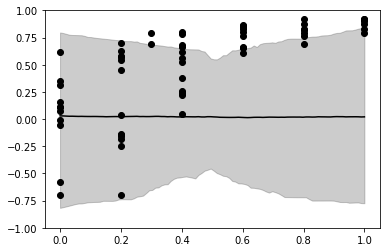

In [12]:

groupsize = 1024

df_trial = df_train[df_train["groupsize"] == groupsize].groupby("trial_category")

plt.errorbar(
    x=df_trial.mean()["coherence"].values,
    y=df_trial.mean()["rotation"].values,
    #xerr=np.stack([
    #    df_trial.median()["coherence"].values - df_trial.quantile(0.055)["coherence"].values,
    #    df_trial.quantile(0.945)["coherence"].values - df_trial.median()["coherence"].values,
    #]),
    #yerr=np.stack([
    #    df_trial.median()["rotation"].values - df_trial.quantile(0.055)["rotation"].values,
    #    df_trial.quantile(0.945)["rotation"].values - df_trial.median()["rotation"].values,
    #]),
    fmt='ko'
)

coherence_seq = jnp.linspace(0,1,100)#np.arange(0, 11) / 10
post_pred = Predictive(model, num_samples=1000)(
    random.PRNGKey(2),
    coherence=coherence_seq.reshape(-1, 1),
    groupsize=jnp.ones_like(coherence_seq).reshape(-1, 1) * groupsize,
    n_trials=len(trial_lookup),
    trial=jnp.ones_like(coherence_seq, dtype=int),
    date=jnp.ones_like(coherence_seq, dtype=int),
    n_dates=len(date_lookup),
    inference=True
)

PI = jnp.percentile((post_pred["loc"] * 2) - 1, [50, 5.5, 94.5], axis=0).squeeze()
#HPDI = hpdi((post_pred["loc"] * 2) - 1, 0.89).squeeze()

plt.plot(coherence_seq, PI[0], "k-")
plt.fill_between(coherence_seq, PI[1], PI[2], color="k", alpha=0.2)
plt.ylim(-1, 1)
plt.show()

In [ ]:
sampler = NUTS(model)
mcmc = MCMC(sampler, num_samples=1000, num_warmup=2000, num_chains=1)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key,
         coherence=df_train['coherence'].values.reshape(-1, 1),
         groupsize=df_train['groupsize'].values.reshape(-1, 1),
         trial=df_train['trial_category'].values,
         n_trials=len(trial_lookup),
         date=df_train['date_category'].values,
         n_dates=len(date_lookup),
         rotation=df_train['rotation'].values.reshape(-1, 1)
        ) 

posterior = mcmc.get_samples()


/home/jake/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Missing a plate statement for batch dimension -1 at site 'w0_base'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  # This is added back by InteractiveShellApp.init_path()
/home/jake/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Missing a plate statement for batch dimension -2 at site 'w0_base'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  # This is added back by InteractiveShellApp.init_path()
/home/jake/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Missing a plate statement for batch dimension -1 at site 'b0_base'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  # This is added back by InteractiveShellApp.init_path()
warmup:  23%|██▎       | 679/3000 [10:50<20:49,  1.86it/s, 127 steps of size 3.81e-02. a

In [ ]:
print_summary(posterior, 0.89, False)

In [ ]:
#guide = numpyro.infer.autoguide.AutoLowRankMultivariateNormal(model)

#svi = SVI(model,
#          guide,
#          optim.Adam(0.001),
#          Trace_ELBO(),
#          coherence=df_train['coherence'].values.reshape(-1, 1),
#          groupsize=df_train['groupsize'].values.reshape(-1, 1),
#          trial=df_train['trial_category'].values,
#          n_trials=len(trial_lookup),
#          date=df_train['date_category'].values,
#          n_dates=len(date_lookup),
#          rotation=df_train['rotation'].values.reshape(-1, 1)
#         )
#svi_results = svi.run(random.PRNGKey(0), 10000)
#posterior = guide.sample_posterior(random.PRNGKey(1), svi_results.params, (1000,))
#plt.plot(svi_results.losses)

In [22]:
test_pred = Predictive(model, posterior)(
    random.PRNGKey(2),
    coherence=df_test['coherence'].values.reshape(-1, 1),
    groupsize=df_test['groupsize'].values.reshape(-1, 1),
    trial=df_test['trial_category'].values,
    n_trials=len(trial_lookup),
    date=df_test['date_category'].values,
    n_dates=len(date_lookup),
    rotation=df_test['rotation'].values.reshape(-1, 1),
    inference=True
)


In [23]:
train_pred = Predictive(model, posterior)(
    random.PRNGKey(2),
    coherence=df_train['coherence'].values.reshape(-1, 1)[:10000],
    groupsize=df_train['groupsize'].values.reshape(-1, 1)[:10000],
    trial=df_train['trial_category'].values[:10000],
    n_trials=len(trial_lookup),
    date=df_train['date_category'].values[:10000],
    n_dates=len(date_lookup),
    rotation=df_train['rotation'].values.reshape(-1, 1)[:10000],
    inference=True
)


In [24]:
prior_pred = Predictive(model, num_samples=3000)(
    random.PRNGKey(2),
    coherence=df_train['coherence'].values.reshape(-1, 1)[:10000],
    groupsize=df_train['groupsize'].values.reshape(-1, 1)[:10000],
    trial=df_train['trial_category'].values[:10000],
    n_trials=len(trial_lookup),
    date=df_train['date_category'].values[:10000],
    n_dates=len(date_lookup),
    rotation=df_train['rotation'].values.reshape(-1, 1)[:10000],
    inference=True
)


In [25]:
train_metrics_df = pd.DataFrame()
prior_metrics_df = pd.DataFrame()
test_metrics_df = pd.DataFrame()

train_metrics_df["log likelihood"] = train_pred["log likelihood"].mean(0).flatten()
train_metrics_df["set"] = "train"

prior_metrics_df["log likelihood"] = prior_pred["log likelihood"].mean(0).flatten()
prior_metrics_df["set"] = "prior"

test_metrics_df["log likelihood"] = test_pred["log likelihood"].mean(0).flatten()
test_metrics_df["set"] = "test"



plot_df = pd.concat([train_metrics_df, test_metrics_df])

In [26]:
import seaborn as sns

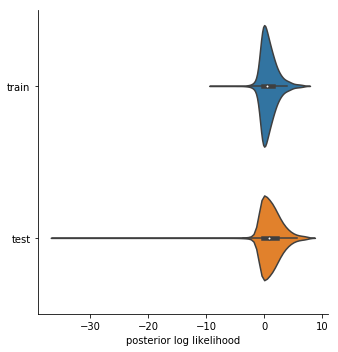

In [29]:
sns.catplot("log likelihood", "set", data=plot_df, kind="violin", bw=0.3)
plt.ylabel("")
plt.xlabel("posterior log likelihood")
plt.savefig("./figures/model_validation.pdf", bbox_inches="tight")
plt.savefig("./figures/model_validation.svg", bbox_inches="tight")

In [30]:
#print_summary(posterior, 0.89, False)

In [31]:
posterior.keys()

dict_keys(['b0', 'b0_base', 'b0_loc', 'b0_scale', 'b0_scale_base', 'w0', 'w0_base', 'w0_loc', 'w0_scale', 'w0_scale_base'])

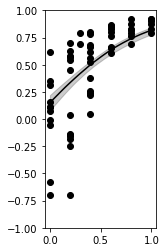

In [32]:
groupsize = 1024

df_trial = df_train[df_train["groupsize"] == groupsize].groupby("trial_category")
plt.figure(figsize=(2,4))

plt.errorbar(
    x=df_trial.mean()["coherence"].values,
    y=df_trial.mean()["rotation"].values,
    #xerr=np.stack([
    #    df_trial.median()["coherence"].values - df_trial.quantile(0.055)["coherence"].values,
    #    df_trial.quantile(0.945)["coherence"].values - df_trial.median()["coherence"].values,
    #]),
    #yerr=np.stack([
    #    df_trial.median()["rotation"].values - df_trial.quantile(0.055)["rotation"].values,
    #    df_trial.quantile(0.945)["rotation"].values - df_trial.median()["rotation"].values,
    #]),
    fmt='ko'
)

coherence_seq = np.linspace(0,1,100)#np.arange(0, 11) / 10
post_pred = Predictive(model, posterior)(random.PRNGKey(2), coherence=coherence_seq.reshape(-1, 1), groupsize=jnp.ones_like(coherence_seq).reshape(-1,1) * groupsize, inference=True)
PI = jnp.percentile((post_pred["loc"] * 2) - 1, [50, 5.5, 94.5], axis=0).squeeze()
plt.plot(coherence_seq, PI[0], "k-")
plt.fill_between(coherence_seq, PI[1], PI[2], color="k", alpha=0.2)
plt.ylim(-1, 1)
plt.show()

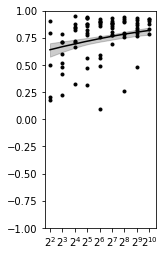

In [33]:
coherence = 1

df_trial = df_train[df_train["coherence"] == coherence].groupby("trial_category")
plt.figure(figsize=(2,4))

plt.errorbar(
    x=df_trial.mean()["groupsize"].values,
    y=df_trial.mean()["rotation"].values,
    #xerr=np.stack([
    #    df_trial.median()["coherence"].values - df_trial.quantile(0.055)["coherence"].values,
    #    df_trial.quantile(0.945)["coherence"].values - df_trial.median()["coherence"].values,
    #]),
    #yerr=np.stack([
    #    df_trial.median()["rotation"].values - df_trial.quantile(0.055)["rotation"].values,
    #    df_trial.quantile(0.945)["rotation"].values - df_trial.median()["rotation"].values,
    #]),
    fmt='k.'
)

groupsize_seq = np.logspace(2, 10, 100, base=2, dtype=np.int32)
post_pred = Predictive(model, posterior)(random.PRNGKey(2), coherence=jnp.ones_like(groupsize_seq).reshape(-1,1) * coherence, groupsize=groupsize_seq.reshape(-1,1), inference=True)
PI = jnp.percentile((post_pred["loc"] * 2) - 1, [50, 5.5, 94.5], axis=0).squeeze()
plt.plot(groupsize_seq, PI[0], "k-")
plt.fill_between(groupsize_seq, PI[1], PI[2], color="k", alpha=0.2)
#plt.xticks([0, 4, 8, 16, 32, 64, 128, 256, 512, 1024])
plt.gca().set_xscale('log', basex=2)
plt.xlim(3, 1536)
plt.xticks([4, 8, 16, 32, 64, 128, 256, 512, 1024])

plt.ylim(-1, 1)
plt.show()

In [34]:
from tensorflow_probability import distributions as tfd

In [37]:
import tqdm
n_samples = 1000

coherences =  np.arange(0, 11) / 10
groupsizes = np.logspace(2, 10, 9, base=2, dtype=np.int32)

n_coherence = coherences.shape[0]
n_groupsize = groupsizes.shape[0]

mean = np.zeros((n_coherence, n_groupsize, n_samples))
var = np.zeros((n_coherence, n_groupsize, n_samples))
entropies = np.zeros((n_coherence, n_groupsize, n_samples))
cdf = np.zeros((n_coherence, n_groupsize, n_samples))
cwsamples = np.zeros((n_coherence, n_groupsize, n_samples))
ccwsamples = np.zeros((n_coherence, n_groupsize, n_samples))
roc_auc = np.zeros((n_coherence, n_groupsize))

for groupsize_idx, groupsize in tqdm.tqdm(enumerate(groupsizes)):
    for coherence_idx, coherence in enumerate(coherences):
        ones = jnp.ones((1,1))
        post_pred = Predictive(model, posterior)(
            random.PRNGKey(2), coherence=ones * coherence, groupsize=ones * groupsize, inference=True
        )

        likelihood = tfd.Beta(post_pred["A"].squeeze(), post_pred["B"].squeeze())
        entropies[coherence_idx, groupsize_idx] = likelihood.entropy().numpy().flatten()
        mean[coherence_idx, groupsize_idx] = likelihood.mean().numpy().flatten()
        var[coherence_idx, groupsize_idx] = likelihood.variance().numpy().flatten()
        cdf[coherence_idx, groupsize_idx] = (1 - likelihood.cdf(0.5)).numpy().flatten()
        cwsamples[coherence_idx, groupsize_idx] = likelihood.sample().numpy().flatten()
        ccwsamples[coherence_idx, groupsize_idx] = 1-likelihood.sample().numpy().flatten()
        y_score = np.concatenate((cwsamples[coherence_idx,groupsize_idx], ccwsamples[coherence_idx,groupsize_idx]))
        y_true = np.concatenate((np.ones(y_score.shape[0]//2), np.zeros(y_score.shape[0]//2)))
        roc_auc[coherence_idx, groupsize_idx] = roc_auc_score(y_true, y_score)


9it [01:26,  9.62s/it]


9it [00:00, 29.85it/s]


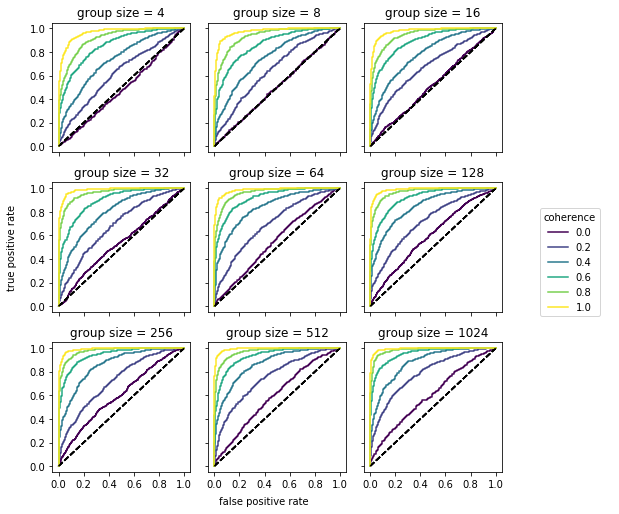

In [38]:
fig, axes = plt.subplots(3, 3, figsize=(7,7), sharex=True, sharey=True)
for groupsize_idx, groupsize in tqdm.tqdm(enumerate(groupsizes)):
    ax = axes.flatten()[groupsize_idx]
    for coherence_idx, coherence in enumerate(coherences):
        if coherence_idx % 2 == 0:
            y_score = np.concatenate((cwsamples[coherence_idx,groupsize_idx], ccwsamples[coherence_idx,groupsize_idx]))
            y_true = np.concatenate((np.ones(y_score.shape[0]//2), np.zeros(y_score.shape[0]//2)))
            fpr, tpr, thresholds = roc_curve(y_true, y_score)
            if groupsize_idx == 0:
                ax.plot(fpr, tpr, color=plt.cm.viridis(coherence), label=coherence)
            else:
                ax.plot(fpr, tpr, color=plt.cm.viridis(coherence))
            ax.set_title("group size = " + str(groupsize))
            ax.plot([0,1], [0,1], 'k--')
            ax.set_xticks(np.arange(11)[::2]/10)
fig.legend(loc="center right", bbox_to_anchor=(1.2, 0.5), title="coherence")
fig = plt.gcf()
fig.text(0.5, -0.01, 'false positive rate', ha='center')
fig.text(-0.01, 0.5, 'true positive rate', va='center', rotation='vertical')
plt.tight_layout()
plt.savefig('./figures/roc_curves_group.pdf', bbox_inches='tight')
plt.savefig('./figures/roc_curves_group.svg', bbox_inches='tight')
plt.show()

9it [00:00, 215.14it/s]
9it [00:00, 203.09it/s]
9it [00:00, 200.07it/s]
9it [00:00, 215.32it/s]
9it [00:00, 202.65it/s]
9it [00:00, 196.23it/s]


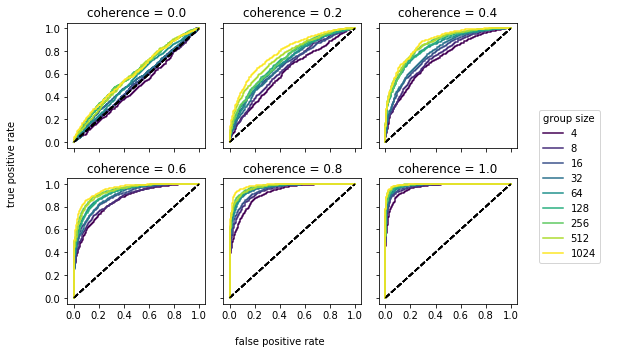

In [39]:
def log2(x):
    return np.log(x) / np.log(2)

fig, axes = plt.subplots(2, 3, figsize=(7,7*0.666), sharex=True, sharey=True)
for coherence_idx, coherence in enumerate(coherences):
    if coherence_idx % 2 == 0:
        ax = axes.flatten()[coherence_idx // 2]
        for groupsize_idx, groupsize in tqdm.tqdm(enumerate(groupsizes)):
            y_score = np.concatenate((cwsamples[coherence_idx,groupsize_idx], ccwsamples[coherence_idx,groupsize_idx]))
            y_true = np.concatenate((np.ones(y_score.shape[0]//2), np.zeros(y_score.shape[0]//2)))
            fpr, tpr, thresholds = roc_curve(y_true, y_score)
            if coherence_idx == 0:
                ax.plot(fpr, tpr, color=plt.cm.viridis(log2(groupsize / 4.) / log2(1024. / 4.)), label=groupsize)
            else:
                ax.plot(fpr, tpr, color=plt.cm.viridis(log2(groupsize / 4.) / log2(1024. / 4.)))
            ax.set_title("coherence = " + str(coherence))
            ax.plot([0,1], [0,1], 'k--')
            ax.set_xticks(np.arange(11)[::2]/10)
fig.legend(loc="center right", bbox_to_anchor=(1.2, 0.5), title="group size")
fig = plt.gcf()
fig.text(0.5, -0.04, 'false positive rate', ha='center')
fig.text(-0.04, 0.5, 'true positive rate', va='center', rotation='vertical')
plt.tight_layout()
plt.savefig('./figures/roc_curves_coherence.pdf', bbox_inches='tight')
plt.savefig('./figures/roc_curves_coherence.svg', bbox_inches='tight')
plt.show()

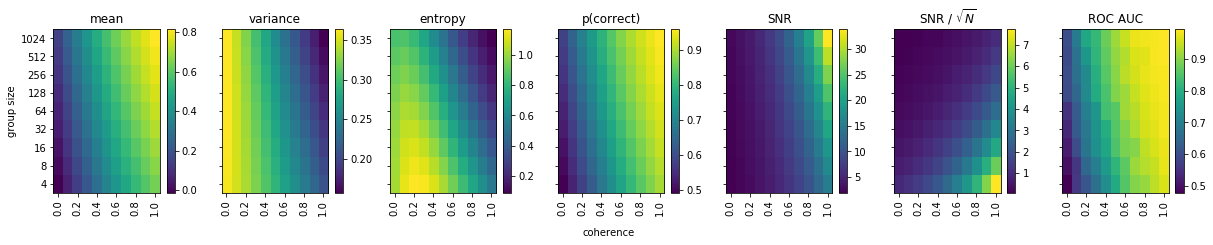

In [40]:
fig, (ax1, ax3, ax2, ax4, ax5, ax6, ax7) = plt.subplots(1, 7, figsize=(17, 3.2), sharey=True)
mean_ = np.mean(mean, axis=-1) * 2 - 1
cax1 = ax1.imshow(mean_.T[::-1], aspect='auto')
cax2 = ax2.imshow(np.exp(np.mean(entropies, axis=-1)).T[::-1] / np.log(2.), aspect='auto')
cax3 = ax3.imshow(np.mean(np.sqrt(var), axis=-1).T[::-1], aspect='auto')
cax4 = ax4.imshow(np.mean(cdf, axis=-1).T[::-1], aspect='auto')
cax5 = ax5.imshow(np.mean(mean**2 / var, axis=-1).T[::-1], aspect='auto')
cax6 = ax6.imshow(np.mean((mean**2 / var) / np.sqrt(np.logspace(2, 10, 9, base=2)[None, :, None]), axis=-1).T[::-1], aspect='auto')
cax7 = ax7.imshow(roc_auc.T[::-1], aspect='auto')

ax1.set_yticks(np.arange(n_groupsize))
ax1.set_yticklabels([str(x) for x in groupsizes[::-1]])
ax1.set_xticks(np.arange(n_coherence)[::2])
ax1.set_xticklabels([str(x) for x in coherences[::2]], rotation=90)
ax1.set_title("mean")

ax2.set_yticks(np.arange(n_groupsize))
ax2.set_yticklabels([str(x) for x in groupsizes[::-1]])
ax2.set_xticks(np.arange(n_coherence)[::2])
ax2.set_xticklabels([str(x) for x in coherences[::2]], rotation=90)
ax2.set_title("entropy")

ax3.set_yticks(np.arange(n_groupsize))
ax3.set_yticklabels([str(x) for x in groupsizes[::-1]])
ax3.set_xticks(np.arange(n_coherence)[::2])
ax3.set_xticklabels([str(x) for x in coherences[::2]], rotation=90)
ax3.set_title("variance")

ax4.set_yticks(np.arange(n_groupsize))
ax4.set_yticklabels([str(x) for x in groupsizes[::-1]])
ax4.set_xticks(np.arange(n_coherence)[::2])
ax4.set_xticklabels([str(x) for x in coherences[::2]], rotation=90)
ax4.set_title("p(correct)")

ax5.set_yticks(np.arange(n_groupsize))
ax5.set_yticklabels([str(x) for x in groupsizes[::-1]])
ax5.set_xticks(np.arange(n_coherence)[::2])
ax5.set_xticklabels([str(x) for x in coherences[::2]], rotation=90)
ax5.set_title("SNR")

ax6.set_yticks(np.arange(n_groupsize))
ax6.set_yticklabels([str(x) for x in groupsizes[::-1]])
ax6.set_xticks(np.arange(n_coherence)[::2])
ax6.set_xticklabels([str(x) for x in coherences[::2]], rotation=90)
ax6.set_title(r"SNR / $\sqrt{N}$")

ax7.set_yticks(np.arange(n_groupsize))
ax7.set_yticklabels([str(x) for x in groupsizes[::-1]])
ax7.set_xticks(np.arange(n_coherence)[::2])
ax7.set_xticklabels([str(x) for x in coherences[::2]], rotation=90)
ax7.set_title(r"ROC AUC")


plt.colorbar(cax1, label='', ax=ax1)
plt.colorbar(cax2, label='', ax=ax2)
plt.colorbar(cax3, label='', ax=ax3)
plt.colorbar(cax4, label='', ax=ax4)
plt.colorbar(cax5, label='', ax=ax5)
plt.colorbar(cax6, label='', ax=ax6)
plt.colorbar(cax7, label='', ax=ax7)

#plt.ylim(-0.5, 10.5)
ax1.set_ylabel('group size')
#plt.xlabel('group size')
plt.tight_layout()
fig = plt.gcf()
fig.text(0.5, -0.04, 'coherence', ha='center')

plt.savefig('./figures/heatplots.pdf', bbox_inches='tight')
plt.savefig('./figures/heatplots.svg', bbox_inches='tight')

plt.show()


In [41]:
import seaborn as sns

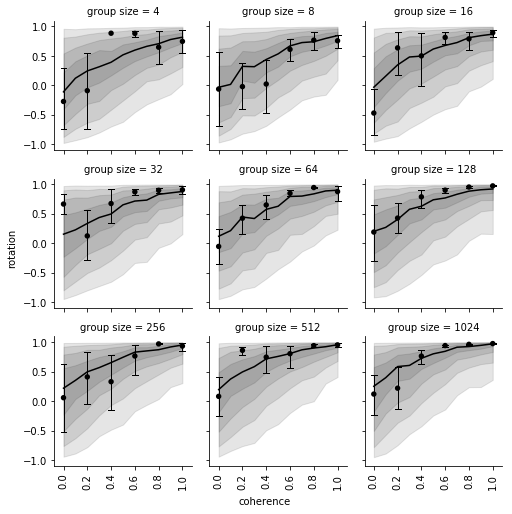

In [42]:
group_means_df = df_test.copy()
group_means_df["coherence"] = np.round(group_means_df["coherence"], decimals=1)
group_means_df = group_means_df[group_means_df['coherence'].isin(np.arange(11)[::2]/10)]
group_means_df = group_means_df.groupby(["trial_category", "coherence", "groupsize"])[["groupsize","coherence", "rotation"]].median()
group_means_df["group size"] = group_means_df["groupsize"]

axes = sns.catplot(x="coherence",
                   y="rotation",
                   col="group size",
                   col_wrap=3,
                   data=group_means_df,
                   palette=[(0,0,0)], 
                   kind="point",
                   join=False,
                   ci=95,
                   estimator=np.mean,
                   n_boot=1000,
                   capsize=0.25,
                   errwidth=1,
                   saturation=1,
                   markers="."
                  )

coherences_int = np.arange(11)/2
alpha=0.1
for idx, ax in enumerate(axes.axes):
    plt.setp(ax.lines, zorder=100)
    plt.setp(ax.collections, zorder=100, label="")
    y = cwsamples[:, idx] * 2 - 1
    perc = np.percentile(y, [0, 100, 5, 95, 10, 90, 15, 85, 20, 80, 25, 75, 30, 70, 35, 65, 40, 60, 45, 55], axis=-1)
    means = np.median(y, axis=-1)
    #ax.fill_between(
    #    coherences_int,
    #    perc[0],
    #    perc[1],
    #    color="k",#plt.cm.tab10([0]),
    #    alpha=alpha
        #label=str(sorted(df["groupsize"].unique())[idx])
    #    )
    ax.fill_between(
        coherences_int,
        perc[4],
        perc[5],
        color="k",#plt.cm.tab10([0]),
        alpha=alpha
        #label=str(sorted(df["groupsize"].unique())[idx])
        )
    ax.fill_between(
        coherences_int,
        perc[8],
        perc[9],
        color="k",#plt.cm.tab10([0]),
        alpha=alpha
        #label=str(sorted(df["groupsize"].unique())[idx])
        )
    ax.fill_between(
        coherences_int,
        perc[12],
        perc[13],
        color="k",#plt.cm.tab10([0]),
        alpha=alpha
        #label=str(sorted(df["groupsize"].unique())[idx])
        )
    ax.fill_between(
        coherences_int,
        perc[16],
        perc[17],
        color="k",#plt.cm.tab10([0]),
        alpha=alpha
        #label=str(sorted(df["groupsize"].unique())[idx])
        )

    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.plot(coherences_int,
             means,
             color="k", #plt.cm.tab10([0])[0],
             label=str(groupsizes[idx])
            )
    ax.set_xticks(coherences_int[::2])
    ax.set_xticklabels(coherences_int[::2]*2/10, rotation="vertical")
    ax.set_ylim(-1.1, 1.1)
fig = plt.gcf()
fig.set_size_inches(7,7)
fig.text(0.5, -0.01, 'coherence', ha='center')
fig.text(-0.01, 0.5, 'rotation', va='center', rotation='vertical')
plt.tight_layout()
plt.savefig('./figures/model_residuals_posterior.pdf', bbox_inches='tight')
plt.savefig('./figures/model_residuals_posterior.svg', bbox_inches='tight')


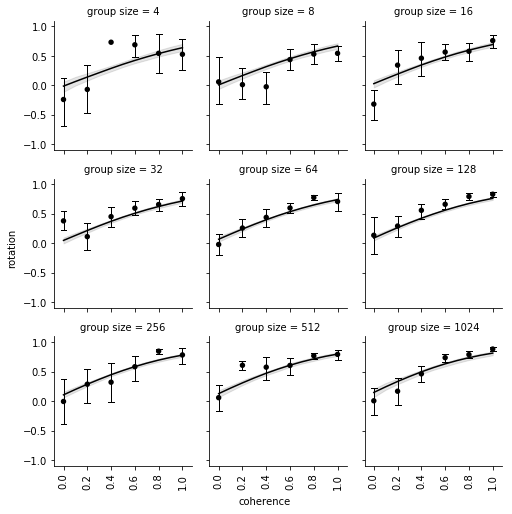

In [43]:
group_means_df = df_test.groupby(["trial_category", "coherence", "groupsize"])[["groupsize","coherence", "rotation"]].mean()
group_means_df["coherence"] = np.round(group_means_df["coherence"], decimals=1)
group_means_df = group_means_df[group_means_df['coherence'].isin(np.arange(11)[::2]/10)]
group_means_df["group size"] = group_means_df["groupsize"]

axes = sns.catplot(x="coherence",
                   y="rotation",
                   col="group size",
                   col_wrap=3,
                   data=group_means_df,
                   palette=[(0,0,0)], 
                   kind="point",
                   join=False,
                   ci=95,
                   capsize=0.25,
                   errwidth=1,
                   estimator=np.mean,
                   markers=".",
                   n_boot=5000)
coherences_int = np.arange(11)/2
for idx, ax in enumerate(axes.axes):
    plt.setp(ax.lines, zorder=100)
    plt.setp(ax.collections, zorder=100, label="")
    y = mean[:, idx] * 2 - 1
    perc = np.percentile(y, [5, 95, 50], axis=-1)
    HPDI = hpdi(y, 0.89, -1)
    ax.fill_between(
        coherences_int,
        HPDI[:, 0],
        HPDI[:, 1],
        color="k",#plt.cm.tab10([0]),
        alpha=0.1
        #label=str(sorted(df["groupsize"].unique())[idx])
        )
    ax.plot(coherences_int,
             perc[2],
             color="k", #plt.cm.tab10([0])[0],
             label=str(groupsizes[idx])
            )
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks(coherences_int[::2])
    ax.set_xticklabels(coherences_int[::2]*2/10, rotation="vertical")
    ax.set_ylim(-1.1, 1.1)
fig = plt.gcf()
fig.set_size_inches(7,7)
fig.text(0.5, -0.01, 'coherence', ha='center')
fig.text(-0.01, 0.5, 'rotation', va='center', rotation='vertical')
plt.tight_layout()
plt.savefig('./figures/model_residuals_mean.pdf', bbox_inches='tight')
plt.savefig('./figures/model_residuals_mean.svg', bbox_inches='tight')
